# 1. Environment Setup and Data Loading

This section prepares the Colab environment for the project. The key steps are:

1.  **Configuration**: Define essential paths and filenames in a centralized configuration block for easy updates.
2.  **Mount Google Drive**: Connect to Google Drive to access the project dataset.
3.  **Unpack Dataset**: The dataset archive (`.zip`) is unpacked from Drive into the local Colab filesystem.

In [1]:
import os
from google.colab import drive

# --- 1. Configuration ---
# Centralized paths and filenames for easy management
GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/EgoVisionProject/Data" # Data folder on Google Drive
ZIP_FILE_NAME    = "ego4d_data.zip"
LOCAL_DATA_PATH  = "/content/data" # Local temporary workspace in Colab

print("Configuration set.")

# --- 2. Mount Google Drive ---
print("Connecting to Google Drive...")
drive.mount('/content/drive', force_remount=True)
print("Drive connected.")

# --- 3. Unpack the Dataset ---
gdrive_zip_file = os.path.join(GDRIVE_PROJECT_PATH, ZIP_FILE_NAME)
print(f"\nLooking for dataset archive at: {gdrive_zip_file}")

if os.path.exists(gdrive_zip_file):
    print("Dataset archive found. Unpacking to local storage...")
    os.makedirs(LOCAL_DATA_PATH, exist_ok=True)

    # Unzip directly from Drive to the local path.
    # -o flag overwrites files without asking, -q flag for quiet mode.
    !unzip -o -q "{gdrive_zip_file}" -d "{LOCAL_DATA_PATH}"
    print("Unpacking complete.")
else:
    print(f"ERROR: Dataset archive not found at '{gdrive_zip_file}'. Please check the path.")

Configuration set.
Connecting to Google Drive...
Mounted at /content/drive
Drive connected.

Looking for dataset archive at: /content/drive/MyDrive/EgoVisionProject/Data/ego4d_data.zip
Dataset archive found. Unpacking to local storage...
Unpacking complete.

--- Verifying contents of the annotations directory: ---
total 2628968
-rw-rw-rw- 1 root root      77019 May  7 13:02 av_test_unannotated.json
-rw-rw-rw- 1 root root  632336417 May  7 13:02 av_train.json
-rw-rw-rw- 1 root root   59129336 May  7 13:02 av_val.json
-rw-rw-rw- 1 root root    6418699 May  7 13:01 fho_hands_test_unannotated.json
-rw-rw-rw- 1 root root   68639174 May  7 13:02 fho_hands_train.json
-rw-rw-rw- 1 root root   45460459 May  7 13:02 fho_hands_val.json
-rw-rw-rw- 1 root root      12113 May  7 13:02 fho_lta_taxonomy.json
-rw-rw-rw- 1 root root   10447110 May  7 13:01 fho_lta_test_unannotated.json
-rw-rw-rw- 1 root root   18234337 May  7 13:01 fho_lta_train.json
-rw-rw-rw- 1 root root   12052154 May  7 13:01 fho_lt

# 2. Exploratory Data Analysis (EDA)

This section focuses on the exploratory analysis of the Ego4D-NLQ dataset. The goals are to:

1.  **Understand Data Structure**: Inspect the format of the annotations.
2.  **Analyze Query Characteristics**: Investigate the distribution of query templates and number of words per query.
3.  **Analyze Temporal Features**: Examine the duration of video clips and answer segments.
4.  **Analyze Video Scenarios**: Explore the distribution of query templates across most common scenarios.

## 2.1 DataFrame Preparation and Initial Inspection

In this first step, we import all the necessary Python libraries for our analysis. We then load the `ego4d_nlq_train.json` annotation file into a pandas DataFrame. Finally, we display the first few rows of the created DataFrame to verify its structure.

In [5]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# Set plot style
sns.set(style='darkgrid')

# --- Correct Path Definition ---
# The setup script unpacks the data into '/content/data'.
ANNOTATIONS_DIR = "/content/data/ego4d_data/v1/annotations"
JSON_FILE_NAME = "nlq_train.json"
json_file_path = os.path.join(ANNOTATIONS_DIR, JSON_FILE_NAME)

print(f"Attempting to load data from: {json_file_path}")

# Check if the file exists before proceeding
if not os.path.exists(json_file_path):
    print(f"ERROR: File not found at '{json_file_path}'.")
    print("Please ensure that the '00_Setup_Environment.ipynb' notebook has been run successfully and the path is correct.")
else:
    # Load the JSON file
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    records = []
    for video_info in data['videos']:
        video_uid = video_info['video_uid']
        for clip_info in video_info['clips']:
            clip_uid = clip_info['clip_uid']
            clip_duration = clip_info["video_end_sec"] - clip_info["video_start_sec"]
            for ann_info in clip_info['annotations']:
                language_queries = ann_info.get('language_queries')
                if language_queries:
                  for query_info in language_queries:
                      answer_start_sec = query_info.get("video_start_sec")
                      answer_end_sec = query_info.get("video_end_sec")

                      answer_duration = None
                      if answer_start_sec is not None and answer_end_sec is not None:
                            answer_duration = answer_end_sec - answer_start_sec

                      records.append({
                            'video_uid': video_uid,
                            'clip_uid': clip_uid,
                            'annotation_uid': ann_info['annotation_uid'],
                            'query': query_info.get("query"),
                            'template': query_info.get("template"),
                            "clip_duration_sec": clip_duration,
                            'start_time': query_info['clip_start_sec'],
                            'end_time': query_info['clip_end_sec'],
                            'response_start_time': answer_start_sec,
                            'response_end_time': answer_end_sec,
                            'response_duration_sec': answer_duration
                      })

    df = pd.DataFrame(records)
    print("DataFrame created successfully.")
    display(df.head())

Attempting to load data from: /content/data/ego4d_data/v1/annotations/nlq_train.json
DataFrame created successfully.


,video_uid,clip_uid,annotation_uid,query,template,clip_duration_sec,start_time,end_time,response_start_time,response_end_time,response_duration_sec
0,d250521e-5197-44aa-8baa-2f42b24444d2,fae92e70-88aa-4b77-b41a-5879b74c804c,f3083484-a6c0-45cb-a40c-b1c2cb470443,How many frying pans can i see on the shelf?,Objects: How many X’s? (quantity question),480.0,0.00000,43.6657,0.021029,43.686729,43.66570
1,d250521e-5197-44aa-8baa-2f42b24444d2,fae92e70-88aa-4b77-b41a-5879b74c804c,f3083484-a6c0-45cb-a40c-b1c2cb470443,What colour bowl did i carry from the plate st...,Objects: What X did I Y?,480.0,55.80900,60.2600,55.830029,60.281029,4.45100
2,d250521e-5197-44aa-8baa-2f42b24444d2,fae92e70-88aa-4b77-b41a-5879b74c804c,f3083484-a6c0-45cb-a40c-b1c2cb470443,In what location did i see the basket?,Objects: In what location did I see object X ?,480.0,62.70855,72.2100,62.729579,72.231029,9.50145
3,d250521e-5197-44aa-8baa-2f42b24444d2,fae92e70-88aa-4b77-b41a-5879b74c804c,f3083484-a6c0-45cb-a40c-b1c2cb470443,What did i pour in the bowl?,Objects: What did I put in X?,480.0,150.49668,154.4890,150.517709,154.510029,3.99232
4,d250521e-5197-44aa-8baa-2f42b24444d2,fae92e70-88aa-4b77-b41a-5879b74c804c,f3083484-a6c0-45cb-a40c-b1c2cb470443,Where was the soap before i picked it up?,Objects: Where is object X before / after even...,480.0,7.16000,8.5180,7.181029,8.539029,1.35800


## 2.2 Analysis of Query Templates

Here, we visualize the counts of each query template using a bar chart to clearly see their frequencies.


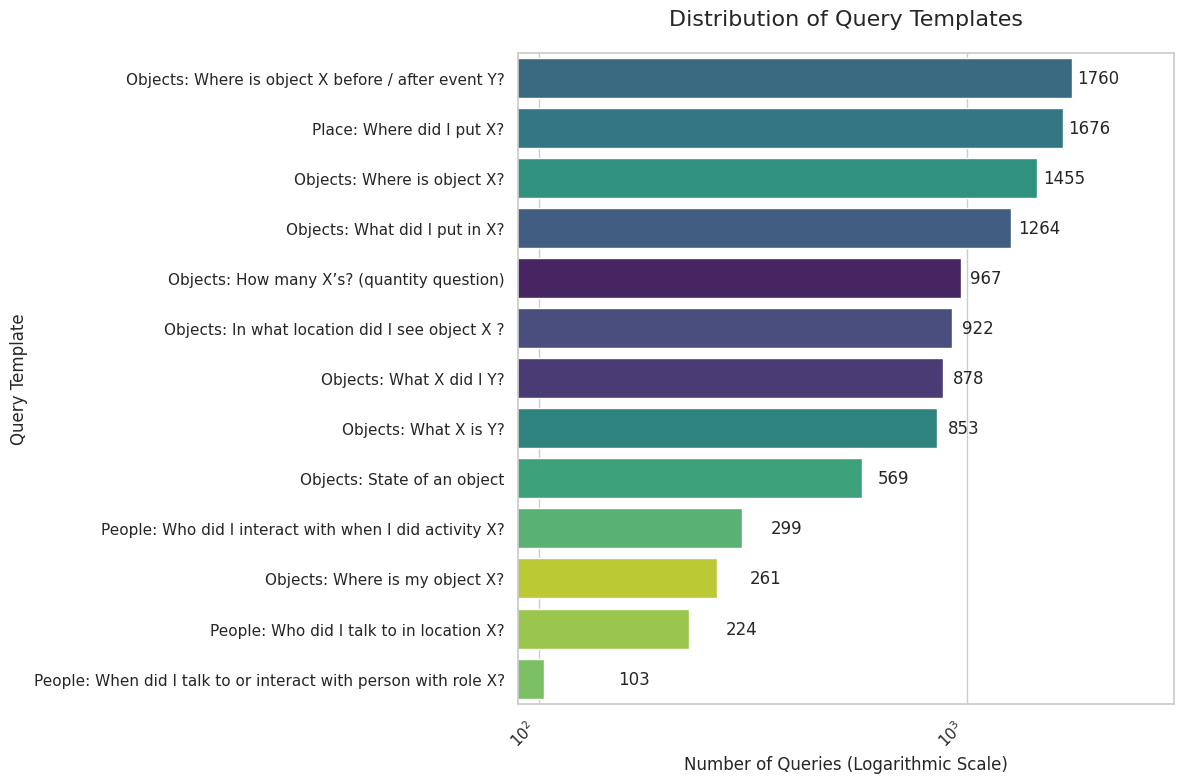

In [27]:
# Graphic settings
sns.set_style("whitegrid")
plt.figure(figsize=(12, 8))

# Create plot and set axes and palette
ax = sns.countplot(
    #y=df['template'],
    y='template',
    data=df,
    order=df['template'].value_counts().index,
    palette='viridis',
    hue='template',
    legend=False
)

# Add titles and labels for clarity
plt.title('Distribution of Query Templates', fontsize=16,pad=20)
plt.xlabel('Number of Queries (Logarithmic Scale)', fontsize=12)
plt.ylabel('Query Template', fontsize=12)
plt.xticks(rotation=45, ha='right') # Rotate labels to prevent overlap
plt.xscale('log')

# Add the count annotations on top of each bar
for p in ax.patches:
    width = p.get_width()
    ax.text(
        width + 50,
        p.get_y() + p.get_height() / 2,
        f'{int(width)}',
        va='center'
    )
# Increase x axis limit to make space for numbers
current_xlim = plt.xlim()
plt.xlim(current_xlim[0], current_xlim[1] * 1.5)

# Ensure everything fits nicely
plt.tight_layout()
plt.show()

## 2.3 Analysis of Clip and Response Durations

We visualize the distributions of the full clip durations and the ground-truth response durations.

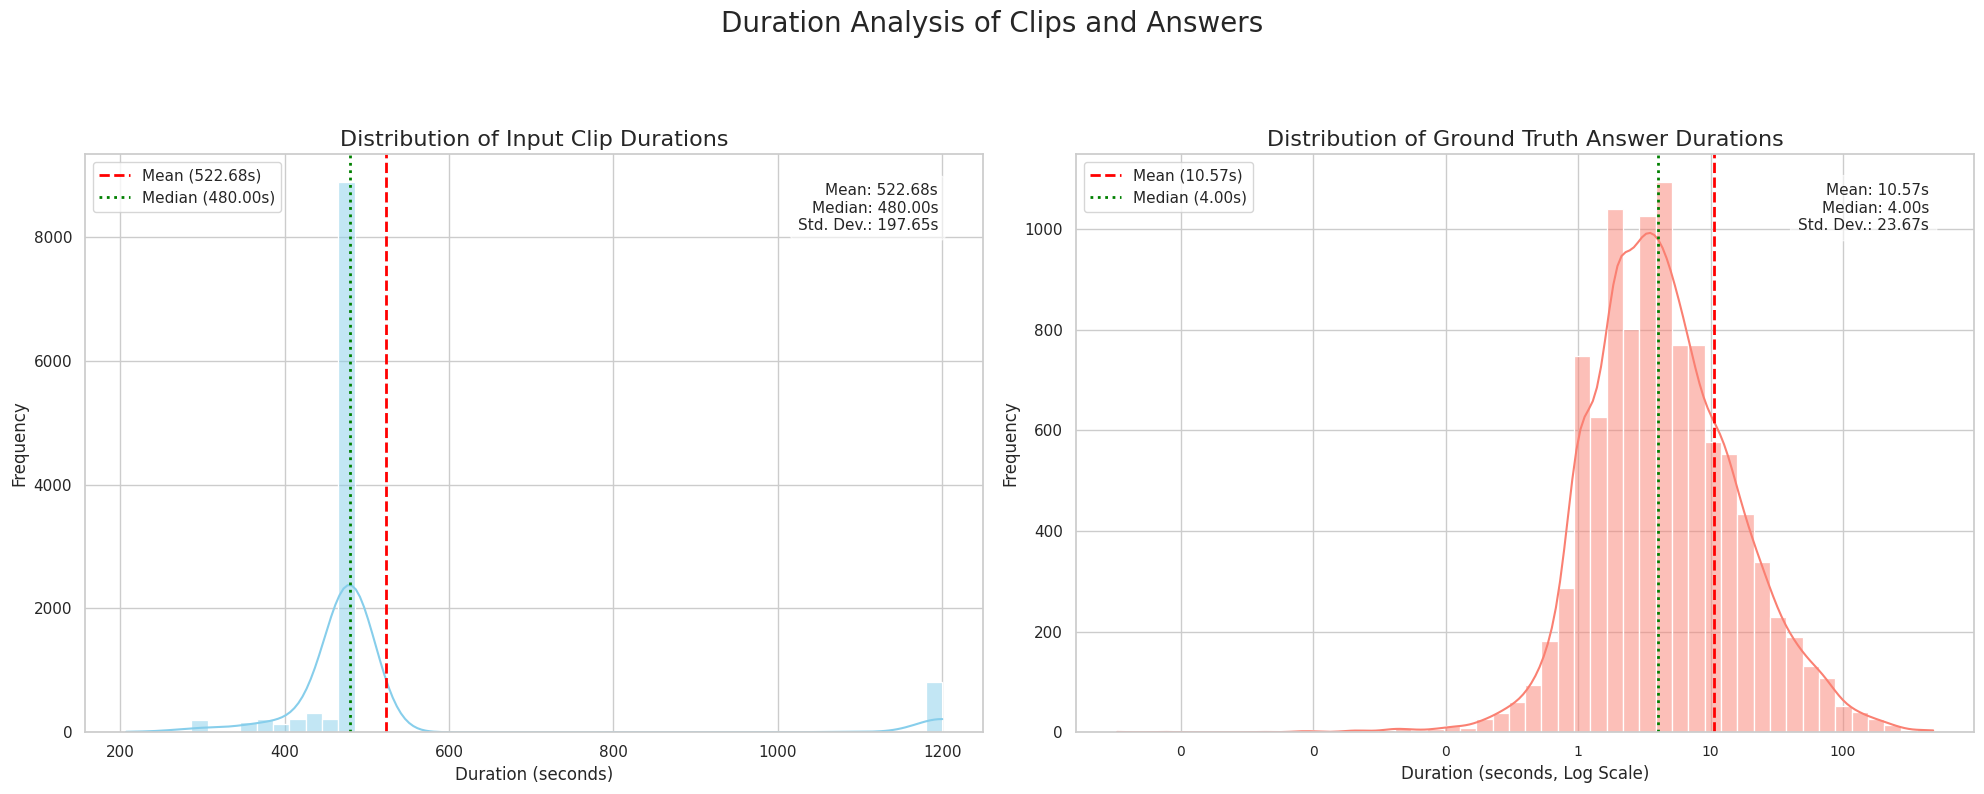

In [28]:
import matplotlib.ticker as mticker

# Assuming the 'full_df' DataFrame has already been loaded and prepared
# Filter for valid durations to ensure proper analysis
answers_df = df[df['response_duration_sec'] > 0].copy()

# --- 1. Calculate descriptive statistics ---
# For clip durations
clip_mean = df['clip_duration_sec'].mean()
clip_median = df['clip_duration_sec'].median()
clip_std = df['clip_duration_sec'].std()

# For answer durations
answer_mean = answers_df['response_duration_sec'].mean()
answer_median = answers_df['response_duration_sec'].median()
answer_std = answers_df['response_duration_sec'].std()

# Prepare the stats text to display on the plots
clip_stats_text = (
    f"Mean: {clip_mean:.2f}s\n"
    f"Median: {clip_median:.2f}s\n"
    f"Std. Dev.: {clip_std:.2f}s"
)
answer_stats_text = (
    f"Mean: {answer_mean:.2f}s\n"
    f"Median: {answer_median:.2f}s\n"
    f"Std. Dev.: {answer_std:.2f}s"
)


# --- 2. Create the Plot ---
fig, axes = plt.subplots(1, 2, figsize=(20, 8))
fig.suptitle('Duration Analysis of Clips and Answers', fontsize=20, y=1.02)


# --- Left Plot: Input Clip Durations ---
sns.histplot(df['clip_duration_sec'], bins=50, ax=axes[0], color='skyblue', kde=True)
axes[0].set_title('Distribution of Input Clip Durations', fontsize=16)
axes[0].set_xlabel('Duration (seconds)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Add vertical lines for mean and median
axes[0].axvline(clip_mean, color='red', linestyle='--', linewidth=2, label=f'Mean ({clip_mean:.2f}s)')
axes[0].axvline(clip_median, color='green', linestyle=':', linewidth=2, label=f'Median ({clip_median:.2f}s)')
axes[0].legend()

# Add the stats box
axes[0].text(0.95, 0.95, clip_stats_text, transform=axes[0].transAxes, fontsize=11,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.6))


# --- Right Plot: Ground Truth Answer Durations ---
sns.histplot(answers_df['response_duration_sec'], bins=50, ax=axes[1], color='salmon', kde=True, log_scale=True)
axes[1].set_title('Distribution of Ground Truth Answer Durations', fontsize=16)
axes[1].set_xlabel('Duration (seconds, Log Scale)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)

# Format the x-axis ticks to show plain numbers instead of powers of 10
axes[1].xaxis.set_major_formatter(mticker.ScalarFormatter())
axes[1].xaxis.get_major_formatter().set_scientific(False)
axes[1].tick_params(axis='x', which='major', labelsize=10)


# Add vertical lines for mean and median
axes[1].axvline(answer_mean, color='red', linestyle='--', linewidth=2, label=f'Mean ({answer_mean:.2f}s)')
axes[1].axvline(answer_median, color='green', linestyle=':', linewidth=2, label=f'Median ({answer_median:.2f}s)')
axes[1].legend()

# Add the stats box
axes[1].text(0.95, 0.95, answer_stats_text, transform=axes[1].transAxes, fontsize=11,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', fc='white', alpha=0.6))


# --- Finalization ---
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 2.4 Analysis of Scenarios and Templates

We now load the `ego4d.json` metadata file to get the official "scenario" for each video. We then analyze how query templates are distributed as a percentage within the top 5 most common scenarios.

--- Generating a Grid of Ordered Bar Charts for Top 5 Scenarios ---

--- Generating Plots ---


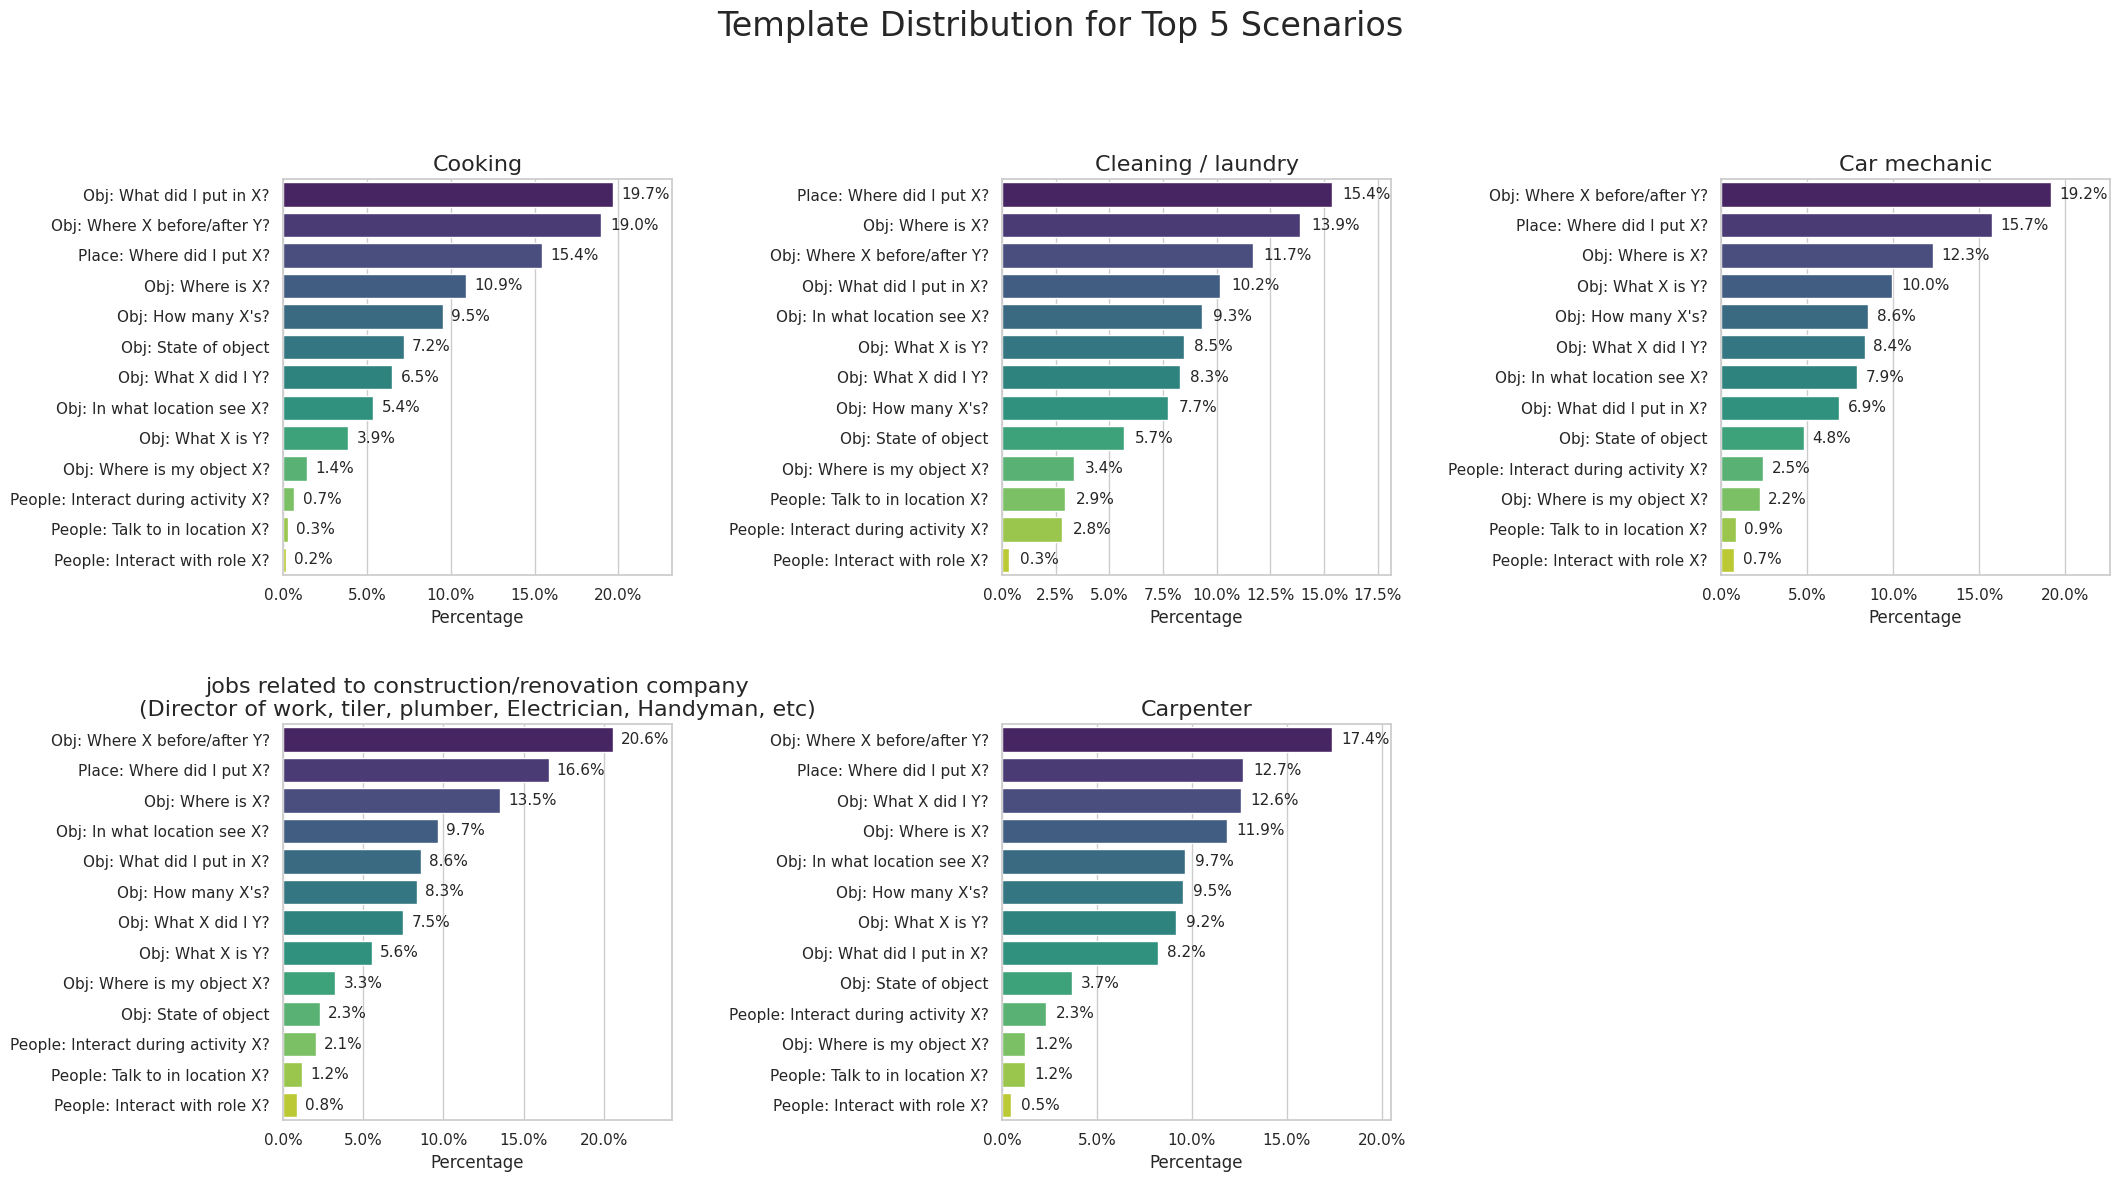

In [31]:
print("--- Generating a Grid of Ordered Bar Charts for Top 5 Scenarios ---")

# --- 1. Data Preparation (Loading and Mapping) ---
try:
    # Load ego4d.json
    ego4d_path = '/content/data/ego4d_data/ego4d.json'
    with open(ego4d_path, 'r') as f:
        ego4d_data = json.load(f)

    # Create a dictionary to map video_uid -> scenario
    video_to_scenario = {}
    for video_info in ego4d_data.get("videos", []):
        if "scenarios" in video_info and video_info["scenarios"]:
            video_to_scenario[video_info["video_uid"]] = video_info["scenarios"][0]

    # Add the 'scenario' column to our main DataFrame
    df['scenario'] = df['video_uid'].map(video_to_scenario)
    full_df_scenario = df.dropna(subset=['scenario'])

    # --- 2. Abbreviate Template & Scenario Labels ---
    # Abbreviate long query templates
    template_map = {
        'Objects: Where is object X before / after event Y?': 'Obj: Where X before/after Y?',
        'Place: Where did I put X?': 'Place: Where did I put X?',
        'Objects: Where is object X?': 'Obj: Where is X?',
        'Objects: What did I put in X?': 'Obj: What did I put in X?',
        "Objects: How many X’s? (quantity question)": "Obj: How many X's?",
        'Objects: In what location did I see object X ?': 'Obj: In what location see X?',
        'Objects: What X did I Y?': 'Obj: What X did I Y?',
        'Objects: What X is Y?': 'Obj: What X is Y?',
        'Objects: State of an object': 'Obj: State of object',
        'People: Who did I interact with when I did activity X?': 'People: Interact during activity X?',
        'Objects: Where is my object X?': 'Obj: Where is my object X?',
        'People: Who did I talk to in location X?': 'People: Talk to in location X?',
        'People: When did I talk to or interact with person with role X?': 'People: Interact with role X?'
    }
    full_df_scenario['short_template'] = full_df_scenario['template'].map(template_map)

    #Abbreviate long scenario names
    scenario_rename_map = {
        'jobs related to construction/renovation company (Director of work, tiler, plumber, Electrician, Handyman, etc)': 'Construction/Renovation Jobs'
    }
    full_df_scenario['scenario'] = full_df_scenario['scenario'].replace(scenario_rename_map)

    # --- 3. Prepare Data for Plotting ---
    contingency_table = pd.crosstab(full_df_scenario['scenario'], full_df_scenario['short_template'])

    # Identify the Top 5 most frequent scenarios
    top_scenarios = contingency_table.sum(axis=1).nlargest(5).index
    filtered_table = contingency_table.loc[top_scenarios]

    # Normalize the data
    normalized_table = filtered_table.div(filtered_table.sum(axis=1), axis=0)

    # --- 4. Create the Grid of Plots Manually for Full Control ---
    print("\n--- Generating Plots ---")

    # Setup the plot grid. For 5 plots, a 2x3 grid is suitable.
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(22, 12))
    # Flatten the axes array to easily iterate over it
    axes = axes.flatten()

    # Iterate through each of the top 5 scenarios and its corresponding subplot axis
    for i, scenario_name in enumerate(top_scenarios):
        ax = axes[i]

        # Get the data for the current scenario, filter out 0% templates, and sort it
        scenario_data = normalized_table.loc[scenario_name]
        scenario_data = scenario_data[scenario_data > 0].sort_values(ascending=False)

        # Create the horizontal bar plot on the specific axis
        sns.barplot(
            x=scenario_data.values,
            y=scenario_data.index,
            ax=ax,
            palette='viridis',
            hue=scenario_data.index,
            legend=False
        )

        # Add the percentage labels next to each bar
        for p in ax.patches:
            width = p.get_width()
            ax.text(
                width + 0.005,  # x position (a small offset from the bar end)
                p.get_y() + p.get_height() / 2, # y position (vertically centered)
                f'{width:.1%}', # The text, formatted as a percentage
                va='center',
                fontsize=11
            )

        # Customize each subplot
        ax.set_title(scenario_name, fontsize=16)
        ax.xaxis.set_major_formatter(mticker.PercentFormatter(1.0))
        ax.set_xlim(0, max(scenario_data.values) * 1.18) # Adjust x-limit to fit labels
        ax.set_xlabel('Percentage', fontsize=12)
        ax.set_ylabel('') # Remove y-label as it's clear from the context

    # Hide any unused subplots in the grid
    for i in range(len(top_scenarios), len(axes)):
        axes[i].set_visible(False)

    # Add a main title for the entire figure
    fig.suptitle('Template Distribution for Top 5 Scenarios', fontsize=24, y=1.01)

    # Adjust layout to prevent titles/labels from overlapping
    fig.tight_layout(pad=3.0)
    plt.show()

except Exception as e:
    print(f"An error occurred: {e}. Please ensure file paths are correct and 'df' is loaded.")

## 2.5 Analysis of Query Length

Finally, we analyze the complexity of the natural language queries themselves. A simple and effective metric for this is the number of words in each query. This analysis helps us understand the verbosity of the questions our model must interpret. We will create a new column in our DataFrame to store the word count for each query and then visualize the distribution of these lengths using a histogram.

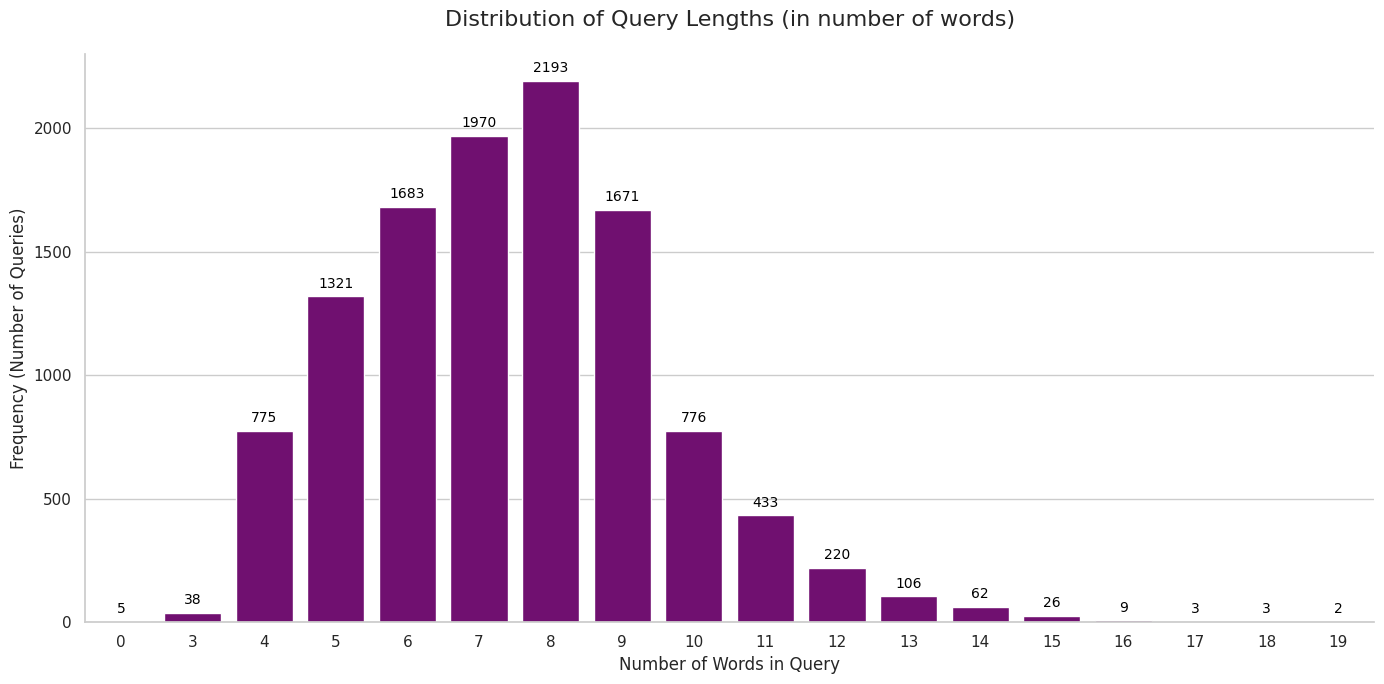

In [24]:
# Compute query lengths
df['query'].fillna('', inplace=True)
df['query_length'] = df['query'].apply(lambda x: len(x.split()))

# 1. Compute frequency of each query length
length_counts = df['query_length'].value_counts().sort_index()

# 2. Create bar chart
plt.figure(figsize=(14, 7))
ax = sns.barplot(
    x=length_counts.index,
    y=length_counts.values,
    color='purple'
)

# 3. Add numbers on the bars (as in the previous bar chart)
for p in ax.patches:
    if p.get_height() > 0:
        ax.annotate(f'{int(p.get_height())}',
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center',
                    va='center',
                    xytext=(0, 9), #vertical offset
                    textcoords='offset points',
                    fontsize=10,
                    color='black')

# 4. Add title and label titles to the chart
ax.set_title('Distribution of Query Lengths (in number of words)', fontsize=16, pad=20)
ax.set_xlabel('Number of Words in Query', fontsize=12)
ax.set_ylabel('Frequency (Number of Queries)', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()